# FFT and Frequency Resolution

*NOTE: This entire notebook is a complete ripoff from the Bitweenie Blog reference below. I claim no credit for the insightful explanations and examples*

Refs
+ [Bitweenie blog article](https://www.bitweenie.com/listings/fft-zero-padding/) by "Shannon Hilbert" on FFT and zero-padding
  + (heh heh--think that's a cleverly chosen handle, but if it's a real name, they are definitely in the right business...) 
+ [Matplotlib tutorial](https://matplotlib.org/3.3.0/gallery/lines_bars_and_markers/psd_demo.html#sphx-glr-gallery-lines-bars-and-markers-psd-demo-py) on PSD plotting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## Zero padding

In [2]:
# Parameters:
n = 1000 # number of samples
f = 1e6 # Hz (first sinusoid)
f2 = 1.05e6 # Hz (second sinusoid)
Fs = 100*f # samples/cycle
# For exponential decay:
half_lives = 10.0 # number of half-lives for exponential decay damping function display
t_half = (n/Fs)*(1/half_lives) # half-life
el = np.log(2)/t_half # decay constant

t = np.linspace(0, (n-1)/Fs, n)

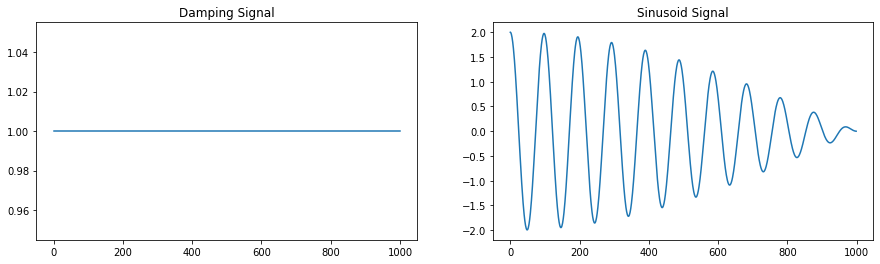

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))

# Damping/Envelope Signal
damping = np.repeat(1, len(t)) # no damping
# damping = np.exp(-el*t) # exponential decay
# damping = (-Fs/n)*t + 1.0 # linear damping
# damping = np.real(np.exp(-1j*(2*np.pi*f/40*t + 0))) # envelope, not really damping
ax1.plot(damping)
ax1.set_title('Damping Signal')

# Sinusoid Signal
#s_t = np.exp(-1j*(2*np.pi*f*t + 0)) # single sinusoid
s_t = np.exp(-1j*2*np.pi*f*t) + np.exp(-1j*2*np.pi*f2*t)
ax2.plot(np.real(s_t))
ax2.set_title('Sinusoid Signal')
plt.show()

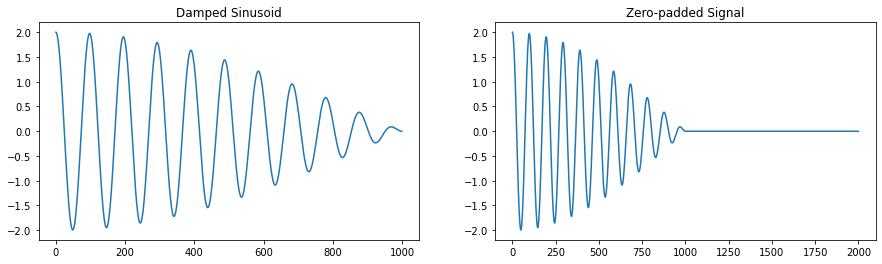

In [4]:
#s_t = np.exp(-(el+1j*2*np.pi*f)*t)
damped = damping*s_t
padded = np.concatenate((damped, np.zeros(n, dtype=np.complex128)))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))
ax1.plot(np.real(damped))
ax1.set_title('Damped Sinusoid')
ax2.plot(np.real(padded))
ax2.set_title('Zero-padded Signal')
plt.show()

From [Bitweenie Blog](https://www.bitweenie.com/listings/fft-zero-padding/):

There are a few reasons why you might want to zero pad time-domain data. The most common reason is to make a waveform have a power-of-two number of samples. When the time-domain length of a waveform is a power of two, radix-2 FFT algorithms, which are extremely efficient, can be used to speed up processing time. FFT algorithms made for FPGAs also typically only work on lengths of power two.

While it’s often necessary to stick to powers of two in your time-domain waveform length, it’s important to keep in mind how doing that affects the resolution of your frequency-domain output.

## Frequency Resolution

There are two aspects of FFT resolution. I’ll call the first one **“waveform frequency resolution”** and the second one **“FFT resolution”**. These are not technical names, but I find them helpful for the sake of this discussion. The two can often be confused because when the signal is not zero padded, the two resolutions are equivalent.

+ The **“waveform frequency resolution”** is the minimum spacing between two frequencies that can be resolved. 

+ The **“FFT resolution”** is the number of points in the spectrum, which is directly proportional to the number points used in the FFT.

It is possible to have extremely fine FFT resolution, yet not be able to resolve two coarsely separated frequencies.

It is also possible to have fine waveform frequency resolution, but have the peak energy of the sinusoid spread throughout the entire spectrum (this is called FFT **spectral leakage**).

### Waveform Frequency Resolution

The **waveform frequency resolution** is defined by the following equation:

$$
{\Delta}R_{waveform} = \frac{1}{{\Delta}T}
$$

where ${\Delta}T$ is the time length of the signal with data. It’s important to note here that you should not include any zero padding in this time! Only consider the actual data samples.

In [5]:
delta_T = n*(1/Fs)
print('Signal Length =', delta_T, 'seconds') # 10 us

delta_R_wf = 1/delta_T
print('Waveform Freq Resolution (Delta R) =', delta_R_wf, 'Hz') # 100 kHz

Signal Length = 1e-05 seconds
Waveform Freq Resolution (Delta R) = 99999.99999999999 Hz


It’s important to make the connection here that the discrete time Fourier transform (DTFT) or FFT operates on the data as if it were an infinite sequence with zeros on either side of the waveform. This is why the FFT has the distinctive `sinc` function shape at each frequency bin.

You should recognize the waveform resolution equation $1/T$ is the same as the space between nulls of a `sinc` function.

### FFT Resolution

The **FFT resolution** is defined by the following equation:

$$
{\Delta}R_{FFT} = \frac{f_s}{N_{FFT}}
$$

In [6]:
print('For a sampling frequency of', Fs, 'sps:')
for NFFT in [256, 512, 1024, 2048, 4096]:
    print(' - FFT Resolution a', NFFT, 'point FFT is', Fs/NFFT, 'Hz')

For a sampling frequency of 100000000.0 sps:
 - FFT Resolution a 256 point FFT is 390625.0 Hz
 - FFT Resolution a 512 point FFT is 195312.5 Hz
 - FFT Resolution a 1024 point FFT is 97656.25 Hz
 - FFT Resolution a 2048 point FFT is 48828.125 Hz
 - FFT Resolution a 4096 point FFT is 24414.0625 Hz


Plot the power spectral density (PSD)
+ *NOTE: I used [this stack overflow post](https://stackoverflow.com/questions/48129222/matplotlib-make-plots-in-functions-and-then-add-each-to-a-single-subplot-figure) to figure out how to use custom plotting functions within subplots*

In [7]:
def psd(data, Fs, ax=None, truncate=None, log=False, **kwargs):
    if ax is None:
        ax = plt.gca()
    else:
        ax = ax
    if (type(truncate) == tuple) and (len(truncate) == 2):
        start = truncate[0]
        stop = truncate[1]
    elif type(truncate) == int:
        start = 0
        stop = truncate
#    elif (len(truncate) == len(data)) and (truncate.dtype == 'bool'):    
    else:
        start = 0
        stop = len(data)

    f, Pxx_den = signal.periodogram(data, Fs)

    if log:
        ax.semilogy(f[start:stop], Pxx_den[start:stop], **kwargs)
    else:
        ax.plot(f[start:stop], Pxx_den[start:stop], **kwargs)

    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('PSD [V**2/Hz]')

    return f, Pxx_den, ax

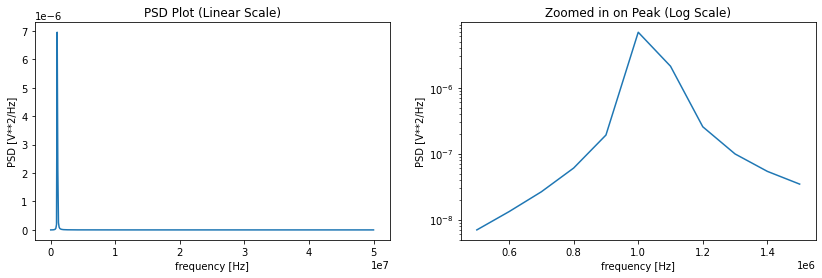

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))

*_, psd_ax1 = psd(np.real(damped), Fs, ax=ax1)
psd_ax1.set_title("PSD Plot (Linear Scale)")

freqs, psds, psd_log_ax2 = psd(np.real(damped), Fs, ax=ax2, truncate=(5,16), log=True)
psd_log_ax2.set_title("Zoomed in on Peak (Log Scale)")
plt.show()

In [9]:
print(len(psds))
print(max(psds))

501
6.948929344979106e-06


Two distinct peaks are not shown, and the single wide peak has an amplitude of about $6.75{\times}10^{-6} \frac{V^2}{Hz}$ (11.4 dBm ?). Clearly these results don’t give an accurate picture of the spectrum. There is not enough resolution in the frequency domain to see both peaks.

Let’s try to resolve the two peaks in the frequency domain by using a larger FFT, thus adding more points to the spectrum along the frequency axis. Let’s use a 7000-point FFT. This is done by zero padding the time-domain signal with 6000 zeros (60 us). The zero-padded time-domain signal is shown here:

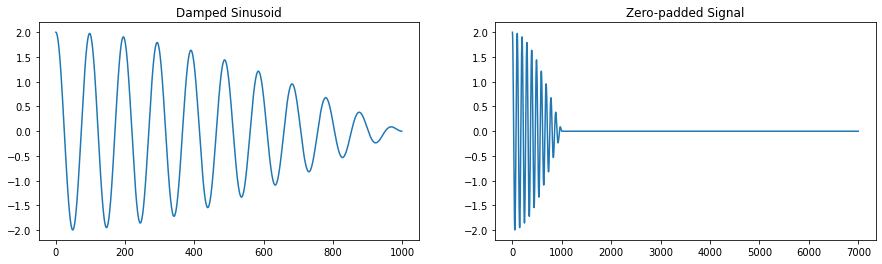

In [10]:
damped = damping*s_t
padded = np.concatenate((damped, np.zeros(6000, dtype=np.complex128)))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))
ax1.plot(np.real(damped))
ax1.set_title('Damped Sinusoid')
ax2.plot(np.real(padded))
ax2.set_title('Zero-padded Signal')
plt.show()

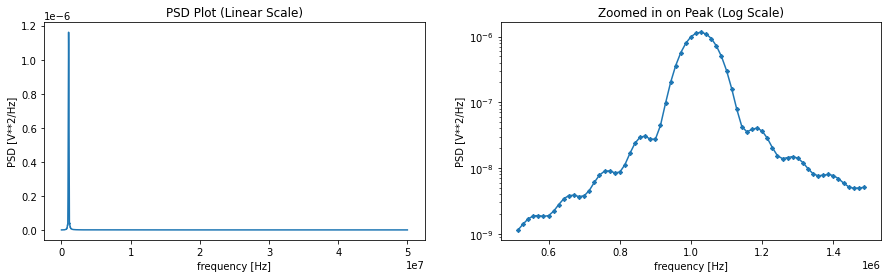

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))

# plot PSD
freqs, psds, psd_ax1 = psd(np.real(padded), Fs, ax=ax1)
psd_ax1.set_title("PSD Plot (Linear Scale)")

# zoom in on peak to see what is going on
mask = (0.5e6 <= freqs) & (freqs <= 1.5e6)
# mask = (-1.5e6 <= freqs) & (freqs <= -0.5e6) # use if complex signal
start = min(np.nonzero(mask)[0])
stop = max(np.nonzero(mask)[0])
*_, psd_log_ax2 = psd(np.real(padded), Fs, ax=ax2, truncate=(start,stop), log=True, marker='D', markersize=3)
psd_log_ax2.set_title("Zoomed in on Peak (Log Scale)")
plt.show()

Although we’ve added many more frequency points, we still cannot resolve the two sinuoids; we are also still not getting the expected power.

Taking a closer look at what this plot is telling us, we see that all we have done by adding more FFT points is to more clearly define the underlying `sinc` function arising from the waveform frequency resolution equation. You can see that the `sinc` nulls are spaced at about 0.1 MHz.

Because our two sinusoids are spaced only 0.05 MHz apart, no matter how many FFT points (zero padding) we use, we will never be able to resolve the two sinusoids.

Let’s look at what the resolution equations are telling us. Although the **FFT resolution** is about 14 kHz (more than enough resoution), the **waveform frequency resolution** is only 100 kHz. The spacing between signals is 50 kHz, so we are being limited by the waveform frequency resolution.

To resolve the spectrum properly, we need to increase the amount of time-domain data we are using. Instead of zero padding the signal out to 70 us (7000 points), let’s capture 7000 points of the waveform. The time-domain and frequency domain results are shown here, respectively.

In [12]:
# Parameters:
n = 7000 # number of samples
f = 1e6 # Hz (first sinusoid)
f2 = 1.05e6 # Hz (second sinusoid)
Fs = 100*f # samples/cycle

t = np.linspace(0, (n-1)/Fs, n)

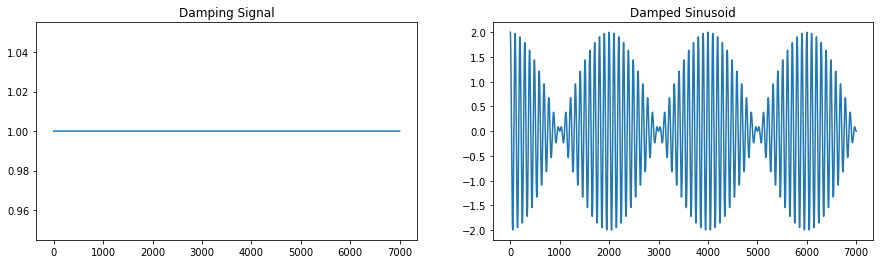

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))

# Damping/Envelope Signal
damping = np.repeat(1, len(t)) # no damping
# damping = np.exp(-el*t) # exponential decay
# damping = (-Fs/n)*t + 1.0 # linear damping
# damping = np.real(np.exp(-1j*(2*np.pi*f/40*t + 0))) # envelope, not really damping
ax1.plot(damping)
ax1.set_title('Damping Signal')

# Sinusoid Signal
s_t = np.real(np.exp(-1j*(2*np.pi*f*t + 0)) + np.exp(-1j*(2*np.pi*f2*t + 0))) # two sinusoids

# Damped Signal
damped = damping*s_t

ax2.plot(np.real(damped))
ax2.set_title('Damped Sinusoid')

plt.show()

In [14]:
delta_T = n*(1/Fs)
#delta_T = n*np.power(Fs, -1)
print('Signal Length =', delta_T, 'seconds')

delta_R_wf = 1/delta_T
#delta_R_wf = np.power(delta_T, -1)
print('Waveform Freq Resolution (Delta R) =', delta_R_wf, 'Hz')

Signal Length = 7.000000000000001e-05 seconds
Waveform Freq Resolution (Delta R) = 14285.714285714284 Hz


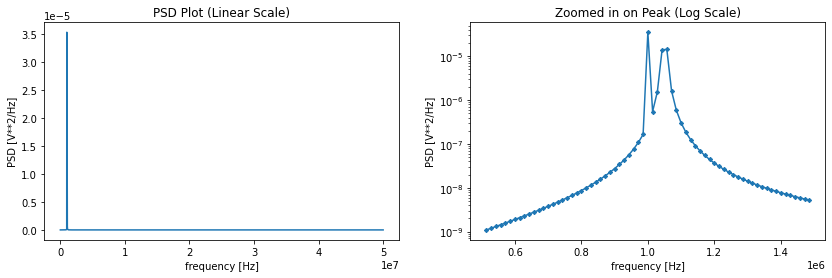

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))

# plot PSD
freqs, psds, psd_ax1 = psd(np.real(damped), Fs, ax=ax1)
psd_ax1.set_title("PSD Plot (Linear Scale)")

# zoom in on peak to see what is going on
mask = (0.5e6 <= freqs) & (freqs <= 1.5e6)
start = min(np.nonzero(mask)[0])
stop = max(np.nonzero(mask)[0])
*_, psd_log_ax2 = psd(np.real(damped), Fs, ax=ax2, truncate=(start,stop), log=True, marker='D', markersize=3)
psd_log_ax2.set_title("Zoomed in on Peak (Log Scale)")
plt.show()

In [16]:
psds[np.argmax(freqs==1e6)]
# TODO: convert V^2/Hz into dBm

1.8826235937108841e-38

With the expanded time-domain data, the waveform frequency resolution is now about 14 kHz as well. As seen in the power spectrum plot, the two sinusoids are not seen. The 1 MHz signal is clearly represented and [**is at the correct power level of 10 dBm (?)**], but the 1.05 MHz signal is wider and not showing the expected power level of 10 dBm. What gives?

What is happening with the 1.05 MHz signal is that we don’t have an FFT point at 1.05 MHz, so the energy is split between multiple FFT bins.

The spacing between FFT points follows the equation:

$$
{\Delta}R_{FFT} = \frac{f_s}{N_{FFT}}
$$

where $N_{FFT}$ is the number of FFT points and $f_s$ is the sampling frequency.

In our example, we’re using a sampling frequency of 100 MHz and a 7000-point FFT. This gives us a spacing between points of 14.28 kHz. The frequency of 1 MHz is a multiple of the spacing, but 1.05 MHz is not. The closest frequencies to 1.05 MHz are 1.043 MHz 1.057 MHz, so the energy is split between the two FFT bins.

To solve this issue, we can choose the FFT size so that both frequencies are single points along the frequency axis. Since we don’t need finer waveform frequency resolution, it’s okay to just zero pad the time-domain data to adjust the FFT point spacing.

In [17]:
padded = np.concatenate((damped, np.repeat(0, 1000)))
len(padded)

8000

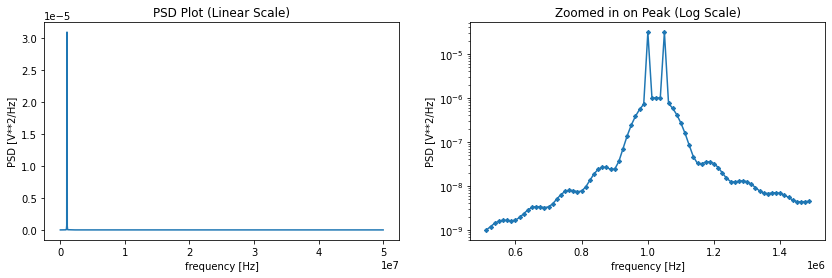

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))

# plot PSD
freqs, psds, psd_ax1 = psd(np.real(padded), Fs, ax=ax1)
psd_ax1.set_title("PSD Plot (Linear Scale)")

# zoom in on peak to see what is going on
mask = (0.5e6 <= freqs) & (freqs <= 1.5e6)
start = min(np.nonzero(mask)[0])
stop = max(np.nonzero(mask)[0])
*_, psd_log_ax2 = psd(np.real(padded), Fs, ax=ax2, truncate=(start,stop), log=True, marker='D', markersize=3)
psd_log_ax2.set_title("Zoomed in on Peak (Log Scale)")
plt.show()

Now both frequencies are resolved [**and at the expected power of 10 dBm (?)**].

For the sake of overkill, you can always add more points to your FFT through zero padding (ensuring that you have the correct waveform resolution) to see the shape of the FFT bins as well. This is shown in the following figure:

In [19]:
padded = np.concatenate((damped, np.repeat(0, 100000)))
len(padded)

107000

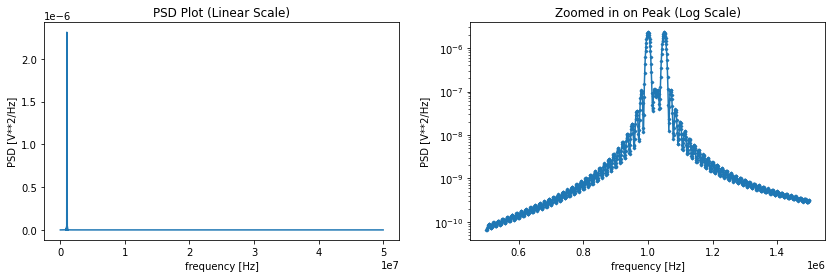

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))

# plot PSD
freqs, psds, psd_ax1 = psd(np.real(padded), Fs, ax=ax1)
psd_ax1.set_title("PSD Plot (Linear Scale)")

# zoom in on peak to see what is going on
mask = (0.5e6 <= freqs) & (freqs <= 1.5e6)
start = min(np.nonzero(mask)[0])
stop = max(np.nonzero(mask)[0])
*_, psd_log_ax2 = psd(np.real(padded), Fs, ax=ax2, truncate=(start,stop), log=True, marker='D', markersize=2)
psd_log_ax2.set_title("Zoomed in on Peak (Log Scale)")
plt.show()

## Choosing the Right FFT Size

Three considerations should factor into your choice of FFT size, zero padding, and time-domain data length.

### What **waveform frequency resolution** do you need?
  + How close together are your frequencies of interest?
  + The **waveform frequency resolution** should be smaller than the minimum spacing between frequencies of interest in order for them to be distinguishable
  + ${\Delta}R_{waveform} = \frac{1}{{\Delta}T}$

### What **FFT resolution** do you need?
  + The **FFT resolution** should at least support the same resolution as your waveform frequency resolution.    Additionally, some highly-efficient implementations of the FFT require that the number of FFT points be a power of two.
  + Choose $f_s$ and $N_{FFT}$ so that ${\Delta}R_{FFT} = \frac{f_s}{N_{FFT}}$ is at least as fine as ${\Delta}R_{waveform}$
  + Consider choosing $N_{FFT}$ that is a power of 2 for more efficient computations

### Does your choice of FFT size allow you to inspect particular **frequencies of interest**?
  + You should ensure that there are enough points in the FFT, or the **FFT has the correct spacing** set, so that your frequencies of interest are not split between multiple FFT points.

One final thought on zero padding the FFT:

If you apply a **windowing function** to your waveform, the windowing function needs to be applied *before zero padding the data*. This ensures that your real waveform data starts and ends at zero, which is the point of most windowing functions.

## The "knobs" you can turn

### You can raise the sampling rate
+ This raises the **maximum component frequency** you can observe (Nyquist frequency), $\frac{1}{2}{\cdot}F_s$
+ But this will *lower* your **FFT resolution** (i.e., each FFT bin will represent a wider frequency bandwidth)

### You can choose a higher $N_{FFT}$
+ This will *raise* your **FFT resolution**, ${\Delta}R_{FFT} = \frac{f_s}{N_{FFT}}$
+ If you don't raise the sampling rate correspondingly, you will need to **zero-pad** the signal, which has the effect of further defining the underlying shape of the `sinc` function which characterizes the FFT bins, but does not actually give you additional information on the frequency content of the signal.

### You can examine a **longer length of time** for the signal
+ This will *raise* your **waveform resolution**, ${\Delta}R_{waveform} = \frac{1}{{\Delta}T}$
